In [ ]:
!pip install -U hopsworks --quiet
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 671.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 741.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.1 MB/s eta 0:00:00
  Preparing met

In [ ]:
import hopsworks
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/188566
Connected. Call `.close()` to terminate connection gracefully.


# Load the dataset from Kaggle

In [ ]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"claraxiang","key":"0f8f6c41b7e9dd22b920256199551872"}'}

In [ ]:
# !mkdir -p ~/.kaggle

# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d kazanova/sentiment140

 80% 65.0M/80.9M [00:00<00:00, 139MB/s]
100% 80.9M/80.9M [00:00<00:00, 143MB/s]


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
!cp -r training.1600000.processed.noemoticon.csv '/content/drive/MyDrive/twitter_dataset/'

cp: cannot stat 'training.1600000.processed.noemoticon.csv': No such file or directory


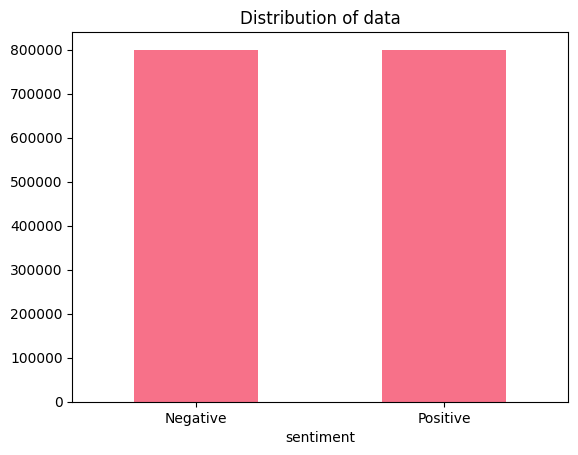

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/twitter_dataset/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

# Preprocess the text

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 153 seconds


# Analyzing the data

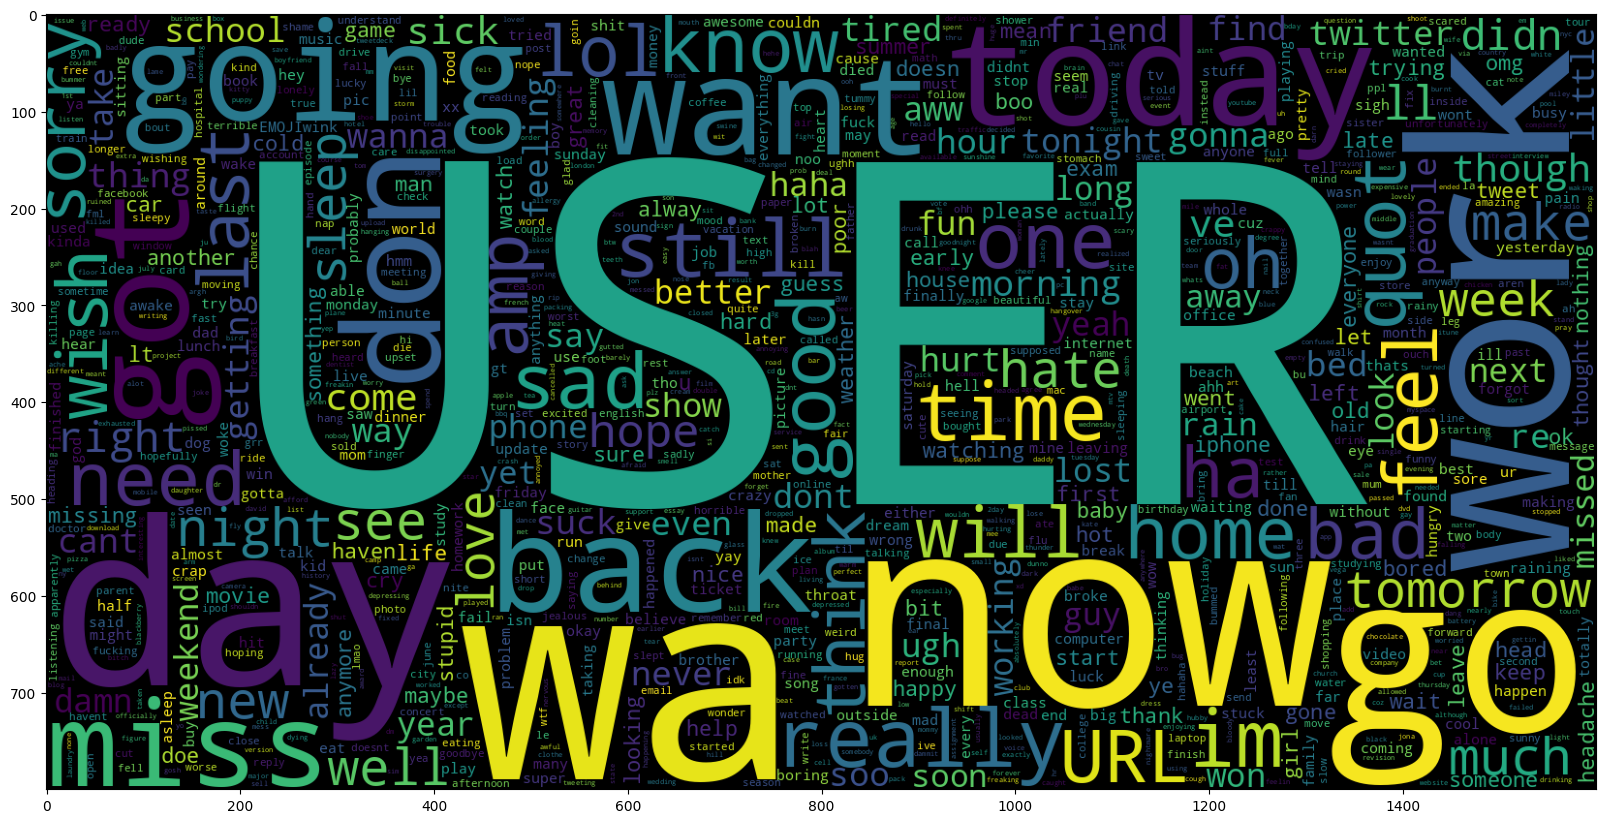

In [ ]:
# word cloud for negative tweets
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

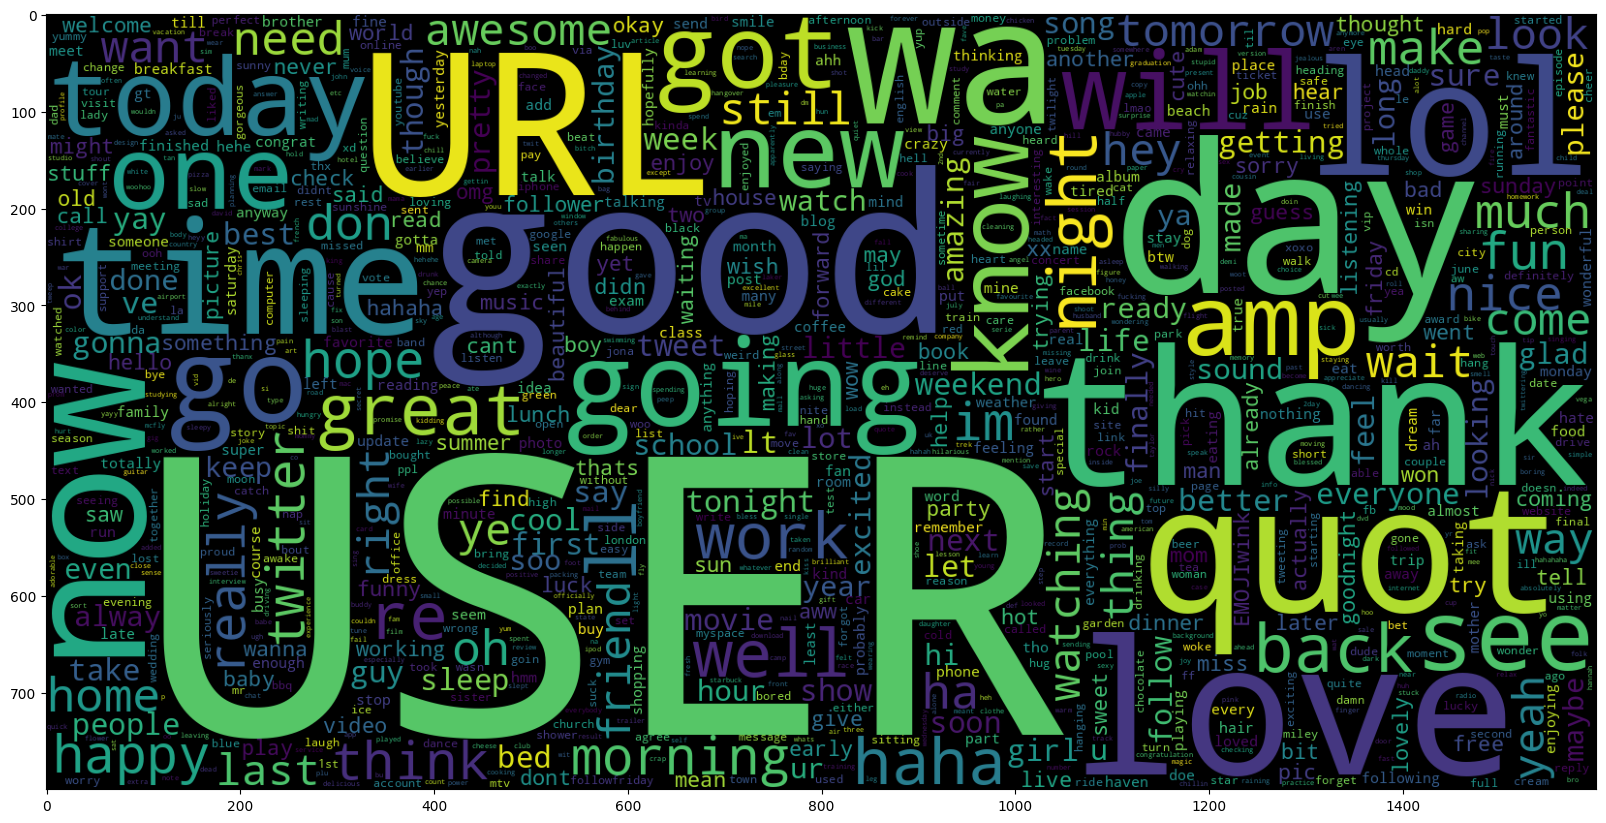

In [ ]:
# word cloud for positive tweets
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
print(processedtext[0:10])

['USER URL aww that bummer you shoulda got david carr of third day to do it EMOJIwink ', 'is upset that he can update his facebook by texting it and might cry a result school today also blah ', 'USER dived many time for the ball managed to save 50 the rest go out of bound ', 'my whole body feel itchy and like it on fire ', 'USER no it not behaving at all mad why am here because can see you all over there ', 'USER not the whole crew ', 'need hug ', 'USER hey long time no see yes rain bit only bit lol fine thanks how you ', 'USER nope they didn have it ', 'USER que me muera ']


In [ ]:
twitter_df = pd.DataFrame({'text': processedtext, 'sentiment': sentiment})

In [ ]:
twitter_df.head()

In [ ]:
twitter_fg = fs.get_or_create_feature_group(
    name="twi_sentiment",
    version=1,
    primary_key=['text','sentiment'],
    description="Twitter dataset")
twitter_fg.insert(twitter_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/188566/fs/188485/fg/353617


Uploading Dataframe: 0.00% |          | Rows 0/1600000 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: twi_sentiment_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/188566/jobs/named/twi_sentiment_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7848dccbe4a0>, None)

=============================================